In [11]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import scipy.sparse as sp
import time
import itertools
import scipy
import highspy

def barycentric_distance(x, y, N):
    # mean squared deviation from the classical barycenter of the xi
    #rescale x and y to be in [0,1]
    x = x / N
    y = y / N
    barycenter = x * 0.5 + y * 0.5
    barycenter = 0.5 * np.sum((x - barycenter) ** 2, axis=0) + 0.5 * np.sum(
        (y - barycenter) ** 2, axis=0)

    return barycenter

def get_cost(N,child):
    #rewrite unravel_index without numpy
    i = np.array([child.transpose()[0] // N, child.transpose()[0] % N])
    j = np.array([child.transpose()[1] // N, child.transpose()[1] % N])
    return barycentric_distance(i,j, N)

def compute_gain_numba(current_kantorovich_u, current_kantorovich_v, cost, children):
    return current_kantorovich_u[children.transpose()[0]] + current_kantorovich_v[children.transpose()[1]] - cost

def find_best_child(parent, half_child,current_kantorovich_u, current_kantorovich_v, N):
    parent_2 = parent.copy()
    parent[1] = half_child
    children = parent.transpose()
    gain = compute_gain_numba(current_kantorovich_u, current_kantorovich_v, get_cost(N, children), children)
    best_gain = np.max(gain)
    best_child = children[np.argmax(gain)]
    if best_gain > 0:
        return best_gain, best_child
    else:
        parent_2[0] = half_child
        children = parent_2.transpose()
        gain = compute_gain_numba(current_kantorovich_u, current_kantorovich_v, get_cost(N, children), children)
        best_gain = np.max(gain)
        best_child = children[np.argmax(gain)]

    return best_gain, best_child


class Genetic_Algorithm:
    def __init__(self, beta, img1, img2):
        self.model = highspy.HighsLp()
        self.model_highs = highspy.Highs()
        self.beta = beta
        self.N = img1.shape[0]
        self.M = img2.shape[0]
        self.img1 = img1.flatten()
        self.img2 = img2.flatten()
        self.b_eq = np.concatenate((self.img1, self.img2))
        
        start = time.time()
        print("initializing omega...")
        self.current_gamma, self.active_indices = self.initialize_omega()
        print("omega initialized in %5.3f. s" %(time.time()-start))
        
        start = time.time()
        print("initializing cost vector...")
        self.current_cost_vector = self.get_cost()
        print("cost vector initialized in %5.3f. s" %(time.time()-start))
        start = time.time()
        print("initializing RMP...")
        self.current_gamma, self.constraints_RMP = self.initialize_RMP()
        print("RMP initialized in %5.3f. s" %(time.time()-start))
        start = time.time()
        print("initializing DRMP...")
        self.current_kantorovich_u, self.current_kantorovich_v, self.constraints_DRMP = self.initialize_DRMP()
        print("DRMP initialized in %5.3f. s" %(time.time()-start))

        #stats
        self.cost = []
        self.time_child = []
        self.children_sampled = []
        self.time_RMP = []
        self.time_DRMP = []
        
    def initialize_RMP(self):

        # Define constraints and bounds for linprog
        bounds = [(0, None) for _ in range(len(self.current_cost_vector))]

        indices_row = np.array([])
        indices_col = np.array([])

        for indices in range(self.N**2):
            gamma_indices = np.where(self.active_indices.transpose()[0] == indices)[0]
            indices_row = np.concatenate((indices_row, gamma_indices))
            indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*indices))

        for indices in range(self.M**2):
            gamma_indices = np.where(self.active_indices.transpose()[1] == indices)[0]
            indices_row = np.concatenate((indices_row, gamma_indices))
            indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*(indices+self.N**2)))

        A_eq = sp.csr_matrix((np.ones(len(indices_col)), (indices_col, indices_row)), shape=( self.N**2 + self.M**2, len(self.active_indices)))
        inf = highspy.kHighsInf
        # Define a HighsLp instance
        # Define constraints and bounds for linprog
        bounds = [(0, None) for _ in range(len(self.current_cost_vector))]
        # Your other code here...
        lp = highspy.Highs()

        lp.addRows(A_eq, -inf, self.b_eq)
        lp.addCols(self.current_cost_vector, -inf, inf)

        lp.setOption("solver", "simplex")
        lp.run()
        res = lp.getSolution()

        if lp.getModelStatus() == lp.getModelStatusString("optimal"):
            return np.array(res.col_value), A_eq
        else:
            raise Exception('The linear programming solver did not find a solution.')




            
        res = scipy.optimize.linprog(self.current_cost_vector, A_ub=None, b_ub=None, A_eq=A_eq, b_eq=self.b_eq, bounds=bounds, method='highs', x0=self.current_gamma)

        if res.success:
            return np.array(res.x), A_eq
        else:
            raise Exception('The linear programming solver did not find a solution.')
        
    
    def initialize_DRMP(self):

        bounds = [(None, None) for _ in range(len(self.b_eq))]
        indices_row = np.array([])
        indices_col = np.array([])
        for index, set in enumerate(self.active_indices):
            row = set.copy()
            row[1] += self.N**2
            indices_row = np.concatenate((indices_row, row))
            indices_col = np.concatenate((indices_col, np.ones(len(set))*index))

        A_ub = sp.csr_matrix((np.ones(len(indices_col)), (indices_col, indices_row)), shape=(len(self.current_cost_vector), self.N**2 + self.M**2))

        b_ub = np.array(self.current_cost_vector)
        res = scipy.optimize.linprog(-self.b_eq, A_ub=A_ub, b_ub=b_ub, A_eq=None, b_eq=None, bounds=bounds, method='highs')

        if res.success:
            current_kantorovich_u = np.array(res.x[:self.N**2])
            current_kantorovich_v = np.array(res.x[self.N**2:])
            return current_kantorovich_u, current_kantorovich_v, A_ub
        else:
            raise Exception('The linear programming solver (dual) did not find a solution.')

    def barycentric_distance(self,x, y):
        # mean squared deviation from the classical barycenter of the xi
        #rescale x and y to be in [0,1]
        x = x / self.N
        y = y / self.M
        barycenter = x * 0.5 + y * 0.5
        barycenter = 0.5 * np.sum((x - barycenter) ** 2) + 0.5 * np.sum(
            (y - barycenter) ** 2)
        return barycenter

    def get_cost(self):
        #for each pair of active pixels, compute the cost of moving the first pixel to the second
        indices_img1 = np.array(np.unravel_index(self.active_indices.transpose()[0], (self.N, self.N))).transpose()
        indices_img2 = np.array(np.unravel_index(self.active_indices.transpose()[1], (self.M, self.M))).transpose()
        cost_vector = np.array([self.barycentric_distance(i, j) for i,j in zip(indices_img1, indices_img2)])
        return cost_vector
    
    def get_single_cost(self, child):
        i = np.array(np.unravel_index(child[0], (self.N, self.N)))
        j = np.array(np.unravel_index(child[1], (self.M, self.M)))
        return self.barycentric_distance(i,j)

    def initialize_omega(self):
        #the north west rule is used to initialise omega
        #we start with the first pixel of each image
        omega = [[0,0]]
        i, j = 0, 0
        b = np.array([self.img1[0], self.img2[0]])
        gamma = []
        current_gamma = [min(b[0], b[1])]
        while i < self.N**2-1 and j < self.M**2-1:
            gamma = min(b[0], b[1])
            b = b - gamma
            if np.argmin(b) == 0:
                i += 1
                b[0] += self.img1[i]
                omega.append([i, j])
                current_gamma.append(gamma)
            else:
                j += 1
                b[1] += self.img2[j]
                omega.append([i, j])
                current_gamma.append(gamma)
        while i < self.N**2-1:
            i += 1
            omega.append([i, j])
            current_gamma.append(0)
        while j < self.M**2-1:
            j += 1
            omega.append([i, j])
            current_gamma.append(0)


        return np.array(current_gamma), np.array(omega)
    
    def run(self, max_iter, chunk_size):
        for _ in tqdm(range(max_iter)):


            best_gain = -1
            best_child = None

            start = time.time()
            non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]
            generator = itertools.product(non_zero_indices, np.arange(self.N**2))
            sample = 0

            while True:
                #slice the generator into chunks of size chunk_size and get separately the non zero indices and the index

                chunk = list(itertools.islice(generator, chunk_size))
                if not chunk:
                    break
                # get the first element for each element of the chunk
                parent, half_child = np.array(chunk).transpose()
                #transform the list of arrays into an array of arrays
                parent = np.array(parent.tolist()).transpose()
                best_gain, best_child = find_best_child(parent, half_child, self.current_kantorovich_u, self.current_kantorovich_v, self.N)

                if best_gain > 0:
                    break
                sample += chunk_size

            if best_gain<=0:
                break
           
            self.children_sampled.append(sample)
            self.time_child.append(time.time() - start)
            self.active_indices = np.vstack((self.active_indices, best_child))
            self.current_cost_vector = np.append(self.current_cost_vector, self.get_single_cost(best_child))
            self.current_gamma = np.append(self.current_gamma, 0)
            if self.active_indices.shape[0] > self.beta*(self.N**2 + self.M**2):
                #delete first (beta-1)*(N^2 + M^2) 0 entries
                zero_indices = np.where(self.current_gamma == 0)[:beta]
                self.active_indices = np.delete(self.active_indices, zero_indices, axis=0)
                self.current_cost_vector = np.delete(self.current_cost_vector, zero_indices)
                self.current_gamma = np.delete(self.current_gamma, zero_indices)
                self.current_gamma, self.constraints_RMP = self.initialize_RMP()
                self.current_kantorovich_u, self.current_kantorovich_v, self.constraints_DRMP = self.initialize_DRMP()
                continue
            self.solve_RMP()
            self.solve_DRMP()



    def compute_gain(self, child):
        return self.current_kantorovich_u[child[0]] + self.current_kantorovich_v[child[1]] - self.get_single_cost(child)


    def solve_RMP(self):
        start = time.time()

        # Define constraints and bounds for linprog
        bounds = [(0, None) for _ in range(len(self.current_cost_vector))]
        A_eq = self.constraints_RMP

        #add a column to A_eq that has a 1 in the coordinate corresponding to the new  child

        child_mu, child_nu = self.active_indices[-1]

        A_col = np.zeros(self.N**2 + self.M**2)
        A_col[child_mu] = 1
        A_col[self.N**2 + child_nu] = 1


        #add the column horizontally
        A_eq = sp.hstack((A_eq, A_col.reshape(-1,1)))

        self.constraints_RMP = A_eq


        res = scipy.optimize.linprog(self.current_cost_vector, A_ub=None, b_ub=None, A_eq=A_eq, b_eq=self.b_eq, bounds=bounds, method='highs-ds', x0=self.current_gamma)

        if res.success:
            self.current_gamma = np.array(res.x)
            self.cost.append(res.fun)
            self.time_RMP.append(time.time() - start)
        else:
            raise Exception('The linear programming solver did not find a solution.')


    def solve_DRMP(self):
        start = time.time()
        # Define constraints and bounds for linprog

        bounds = [(None, None) for _ in range(len(self.b_eq))]
        A_ub = self.constraints_DRMP
        #add a row to A_ub that has a 1 in the coordinate corresponding to the new  child
        A_row = np.zeros(len(self.b_eq))
        child_mu, child_nu = self.active_indices[-1]
        A_row[child_mu] = 1
        A_row[self.N**2 + child_nu] = 1
        A_ub = sp.vstack((A_ub, A_row))
        self.constraints_DRMP = A_ub


        res = scipy.optimize.linprog(-self.b_eq, A_ub=A_ub, b_ub=self.current_cost_vector, A_eq=None, b_eq=None, bounds=bounds, method='highs', x0=np.concatenate((self.current_kantorovich_u, self.current_kantorovich_v)))

        if res.success:
            self.current_kantorovich_u = np.array(res.x[:self.N**2])
            self.current_kantorovich_v = np.array(res.x[self.N**2:])
            self.time_DRMP.append(time.time() - start)
        else:
            raise Exception('The linear programming solver (dual) did not find a solution.')
  
     
    def get_mean(self, par):
        indices_x = np.unravel_index(self.active_indices.transpose()[0], (img1.shape[0], img1.shape[0]))
        indices_y = np.unravel_index(self.active_indices.transpose()[1], (img2.shape[0], img2.shape[0]))
        mean = (par * indices_x[0] + (1 - par) * indices_y[0]).astype('int'), (
                    par * indices_x[1] + (1 - par) * indices_y[1]).astype('int')
        #transform the mean back to a 1d index
        mean = np.ravel_multi_index(mean, (img1.shape[0], img1.shape[0]))
        #check how many coordinates of mean and indices_x are the same
        gamma = sp.csr_matrix((self.current_gamma, (self.active_indices.transpose()[0], mean)),
                              shape=(img1.shape[0] ** 2, img2.shape[0] ** 2))
        return gamma.todense().transpose().dot(normalized_img1.flatten()).reshape(img1.shape[0], img1.shape[0])

    def reduce(self):
        non_zero_indices = np.where(self.current_gamma != 0)[0]
        self.active_indices = self.active_indices[non_zero_indices]
        self.current_cost_vector = self.current_cost_vector[non_zero_indices]
        self.current_gamma = self.current_gamma[non_zero_indices]

    def plot(self):
        plt.close()
        fig, axs = plt.subplots(2, 6)
        axs[0][0].imshow(self.get_mean(1), cmap='gray')
        axs[0][1].imshow(self.get_mean(0.95), cmap='gray')
        axs[0][2].imshow(self.get_mean(0.9), cmap='gray')
        axs[0][3].imshow(self.get_mean(0.8), cmap='gray')
        axs[0][4].imshow(self.get_mean(0.7), cmap='gray')
        axs[0][5].imshow(self.get_mean(0.6), cmap='gray')
        axs[1][0].imshow(self.get_mean(0.5), cmap='gray')
        axs[1][1].imshow(self.get_mean(0.4), cmap='gray')
        axs[1][2].imshow(self.get_mean(0.3), cmap='gray')
        axs[1][3].imshow(self.get_mean(0.2), cmap='gray')
        axs[1][4].imshow(self.get_mean(0.1), cmap='gray')
        axs[1][5].imshow(self.get_mean(0), cmap='gray')
        plt.show()
 

In [12]:
if __name__ == '__main__':
    h = highspy.Highs()
    lambda_parameter = 0.5
    #generate values between 0 and 1
    #load images
    path_img1 = "cat.jpg"
    path_img2 = "dog.jpg"
    img1 = np.array(Image.open(path_img1).convert('L'))
    #switch black and white
    img2 = np.array(Image.open(path_img2).convert('L'))
    img_coordinates = np.array([[(i, j) for i in range(img1.shape[0])] for j in range(img2.shape[0])])

    img_coordinates = img_coordinates.reshape(img1.shape[0]*img2.shape[0], 2)
    normalized_img1 = img1 / 255
    normalized_img2 = img2 / 255
    normalized_img1 = 1 - normalized_img1
    normalized_img2 = 1 - normalized_img2
    normalized_img1 = (normalized_img1 / np.sum(normalized_img1))*img1.shape[0]
    normalized_img2 = (normalized_img2 / np.sum(normalized_img2))*img2.shape[0]
    beta = 3  # hyperparameter
    ga = Genetic_Algorithm(beta=beta, img1=normalized_img1, img2=normalized_img2)

initializing omega...
omega initialized in 0.005. s
initializing cost vector...
cost vector initialized in 0.007. s
initializing RMP...


TypeError: addRows(): incompatible function arguments. The following argument types are supported:
    1. (self: highspy.highs_bindings._Highs, arg0: int, arg1: numpy.ndarray[numpy.float64], arg2: numpy.ndarray[numpy.float64], arg3: int, arg4: numpy.ndarray[numpy.int32], arg5: numpy.ndarray[numpy.int32], arg6: numpy.ndarray[numpy.float64]) -> highspy.highs_bindings.HighsStatus

Invoked with: <highspy.highs.Highs object at 0x13f157290>, <512x511 sparse matrix of type '<class 'numpy.float64'>'
	with 1022 stored elements in Compressed Sparse Row format>, -inf, array([0.00198881, 0.        , 0.        , 0.        , 0.        ,
       0.1690491 , 0.        , 0.00198881, 0.        , 0.00066294,
       0.        , 0.1690491 , 0.00066294, 0.        , 0.        ,
       0.00066294, 0.        , 0.        , 0.00132588, 0.00132588,
       0.        , 0.1690491 , 0.1690491 , 0.        , 0.        ,
       0.        , 0.1690491 , 0.1690491 , 0.        , 0.        ,
       0.0053035 , 0.        , 0.        , 0.00066294, 0.        ,
       0.00066294, 0.        , 0.1690491 , 0.        , 0.1690491 ,
       0.1690491 , 0.16507147, 0.        , 0.16639735, 0.00265175,
       0.        , 0.        , 0.00066294, 0.00066294, 0.        ,
       0.00066294, 0.1690491 , 0.16639735, 0.010607  , 0.        ,
       0.        , 0.00132588, 0.        , 0.00066294, 0.1690491 ,
       0.16573441, 0.1690491 , 0.00066294, 0.00132588, 0.        ,
       0.        , 0.        , 0.        , 0.1690491 , 0.        ,
       0.1690491 , 0.        , 0.        , 0.        , 0.1690491 ,
       0.00198881, 0.1690491 , 0.        , 0.        , 0.        ,
       0.00066294, 0.        , 0.00265175, 0.1690491 , 0.16639735,
       0.00397763, 0.1690491 , 0.        , 0.00132588, 0.00397763,
       0.16573441, 0.        , 0.1690491 , 0.1690491 , 0.        ,
       0.00132588, 0.        , 0.00132588, 0.        , 0.00331469,
       0.1690491 , 0.01126994, 0.1690491 , 0.        , 0.        ,
       0.        , 0.1690491 , 0.16838616, 0.1690491 , 0.        ,
       0.00265175, 0.        , 0.        , 0.00132588, 0.00066294,
       0.16639735, 0.1690491 , 0.1690491 , 0.        , 0.00331469,
       0.1690491 , 0.        , 0.        , 0.1690491 , 0.16838616,
       0.16838616, 0.        , 0.        , 0.00132588, 0.00066294,
       0.        , 0.        , 0.00066294, 0.16838616, 0.16838616,
       0.1690491 , 0.03049513, 0.1690491 , 0.16772322, 0.16772322,
       0.        , 0.00198881, 0.        , 0.00132588, 0.        ,
       0.        , 0.00066294, 0.00066294, 0.        , 0.1690491 ,
       0.00066294, 0.1690491 , 0.16639735, 0.1690491 , 0.00066294,
       0.1690491 , 0.        , 0.00066294, 0.00132588, 0.        ,
       0.00066294, 0.00198881, 0.        , 0.        , 0.1690491 ,
       0.1690491 , 0.00066294, 0.        , 0.00397763, 0.        ,
       0.        , 0.        , 0.1690491 , 0.        , 0.00132588,
       0.00265175, 0.        , 0.00397763, 0.        , 0.1690491 ,
       0.16639735, 0.16706029, 0.00132588, 0.16772322, 0.        ,
       0.1690491 , 0.        , 0.        , 0.16639735, 0.1690491 ,
       0.        , 0.        , 0.00132588, 0.        , 0.1690491 ,
       0.16772322, 0.1690491 , 0.1690491 , 0.00397763, 0.16507147,
       0.1690491 , 0.1690491 , 0.00066294, 0.16838616, 0.1690491 ,
       0.1690491 , 0.16772322, 0.        , 0.00066294, 0.        ,
       0.02055107, 0.1690491 , 0.1690491 , 0.16772322, 0.        ,
       0.1690491 , 0.16706029, 0.16639735, 0.00132588, 0.1690491 ,
       0.16706029, 0.1690491 , 0.1690491 , 0.00198881, 0.        ,
       0.00198881, 0.        , 0.00132588, 0.1690491 , 0.16838616,
       0.16838616, 0.16838616, 0.1690491 , 0.1690491 , 0.1690491 ,
       0.16706029, 0.16706029, 0.        , 0.        , 0.        ,
       0.00198881, 0.        , 0.00066294, 0.00066294, 0.        ,
       0.00066294, 0.1690491 , 0.16706029, 0.16838616, 0.16772322,
       0.16772322, 0.00198881, 0.        , 0.        , 0.00198881,
       0.00066294, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00153743, 0.00153743, 0.        , 0.        ,
       0.00614971, 0.        , 0.        , 0.00307485, 0.        ,
       0.        , 0.        , 0.00307485, 0.        , 0.00461228,
       0.        , 0.00461228, 0.        , 0.        , 0.01076199,
       0.00461228, 0.        , 0.00153743, 0.        , 0.00153743,
       0.        , 0.        , 0.00768713, 0.        , 0.        ,
       0.        , 0.01076199, 0.        , 0.00614971, 0.00461228,
       0.        , 0.        , 0.00307485, 0.        , 0.00922456,
       0.        , 0.00614971, 0.        , 0.        , 0.        ,
       0.00307485, 0.        , 0.        , 0.38743154, 0.38896896,
       0.39204382, 0.39204382, 0.        , 0.        , 0.00307485,
       0.00153743, 0.00614971, 0.        , 0.00307485, 0.00153743,
       0.        , 0.        , 0.00461228, 0.39050639, 0.00461228,
       0.00614971, 0.        , 0.        , 0.00768713, 0.38896896,
       0.00153743, 0.        , 0.        , 0.01076199, 0.        ,
       0.        , 0.        , 0.        , 0.00307485, 0.39204382,
       0.        , 0.        , 0.00461228, 0.        , 0.        ,
       0.00307485, 0.39050639, 0.00922456, 0.00614971, 0.        ,
       0.        , 0.00153743, 0.00461228, 0.        , 0.        ,
       0.        , 0.39204382, 0.00461228, 0.        , 0.39050639,
       0.00307485, 0.00153743, 0.00153743, 0.38281926, 0.39204382,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00153743, 0.        , 0.        , 0.00153743, 0.        ,
       0.00153743, 0.00153743, 0.        , 0.00307485, 0.00153743,
       0.        , 0.39050639, 0.39204382, 0.        , 0.00153743,
       0.00153743, 0.        , 0.        , 0.38896896, 0.39204382,
       0.        , 0.39204382, 0.00153743, 0.        , 0.        ,
       0.00153743, 0.        , 0.00461228, 0.        , 0.39204382,
       0.        , 0.00614971, 0.        , 0.00153743, 0.00153743,
       0.38281926, 0.39204382, 0.00153743, 0.        , 0.00768713,
       0.00307485, 0.        , 0.        , 0.        , 0.01229941,
       0.        , 0.        , 0.39204382, 0.38743154, 0.        ,
       0.00153743, 0.39204382, 0.39204382, 0.        , 0.00768713,
       0.        , 0.        , 0.00922456, 0.        , 0.        ,
       0.        , 0.38743154, 0.        , 0.        , 0.00768713,
       0.00307485, 0.00153743, 0.        , 0.00153743, 0.00307485,
       0.        , 0.00922456, 0.        , 0.        , 0.00153743,
       0.        , 0.00307485, 0.00461228, 0.        , 0.39204382,
       0.39204382, 0.38589411, 0.38589411, 0.39204382, 0.39204382,
       0.38589411, 0.39204382, 0.38743154, 0.39204382, 0.39050639,
       0.39050639, 0.39204382, 0.39050639, 0.38896896, 0.00461228,
       0.        , 0.        , 0.00461228, 0.00307485, 0.00461228,
       0.        , 0.00614971, 0.        , 0.        , 0.00461228,
       0.00153743, 0.        , 0.00153743, 0.00153743, 0.00153743,
       0.00922456, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01076199, 0.        , 0.        , 0.00768713,
       0.        , 0.        , 0.        , 0.00153743, 0.        ,
       0.00461228, 0.        , 0.        , 0.00307485, 0.        ,
       0.00307485, 0.00153743, 0.        , 0.00614971, 0.00153743,
       0.        , 0.00153743, 0.00768713, 0.        , 0.        ,
       0.00768713, 0.        ])

In [7]:
ga.run(max_iter=200, chunk_size=500)
ga.reduce()

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/kl/7vjjry6d5gjg6tbv6l5w90nm0000gn/T/ipykernel_28603/3102584128.py:213: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  parent, half_child = np.array(chunk).transpose()
100%|██████████| 200/200 [00:06<00:00, 30.94it/s]


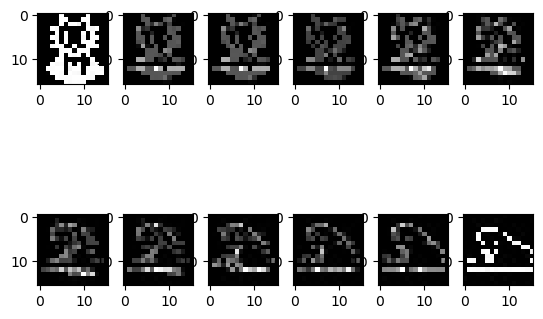

In [4]:
ga.plot()

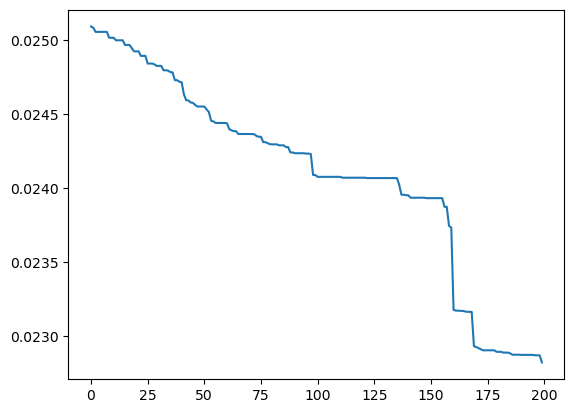

In [8]:
plt.plot(ga.cost)

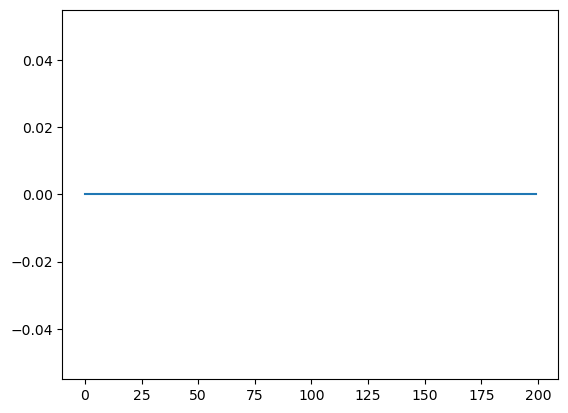

In [9]:
plt.plot(ga.children_sampled)

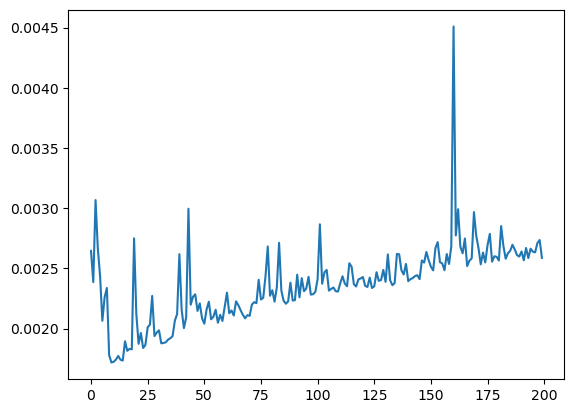

In [10]:
plt.plot(ga.time_RMP)

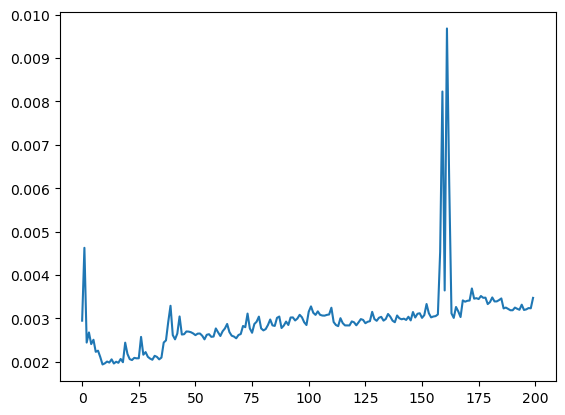

In [11]:
plt.plot(ga.time_DRMP)

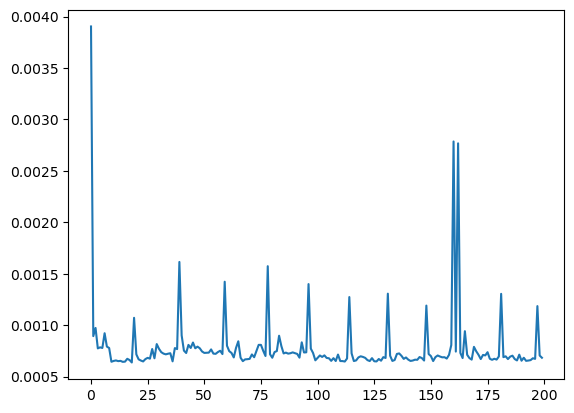

In [12]:
plt.plot(ga.time_child)